# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [5]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

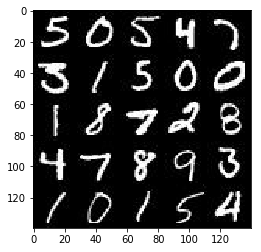

In [6]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

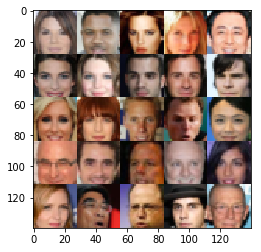

In [7]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [8]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.3.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [17]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, [None, image_width, image_height, image_channels], name='inputs_real')
    inputs_z = tf.placeholder(tf.float32, [None, z_dim], name='inputs_z')
    learning_rate = tf.placeholder(tf.float32, [], name='learning_rate')
    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [18]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.01
    with tf.variable_scope('discriminator', reuse=reuse):
        x1 = tf.layers.conv2d(images, 64, 5, 2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        
        x2 = tf.layers.conv2d(relu1, 128, 5, 2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        
        x3 = tf.layers.conv2d(relu2, 256, 5, 2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        
        flat_disc = tf.reshape(relu3, (-1, 4*4*256))
        logits_disc = tf.layers.dense(flat_disc, 1)
        output_disc = tf.sigmoid(logits_disc)
    return output_disc, logits_disc


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [19]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha = 0.01
    with tf.variable_scope('generator', reuse=not is_train):
        x1 = tf.layers.dense(z, 7*7*512)
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, 1, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, 2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)

        logits_gen = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, 2, padding='same')
        output_gen = tf.tanh(logits_gen)
    return output_gen


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [20]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_logits_real)))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_logits_fake)))
    
    d_loss = d_loss_real + d_loss_fake
    
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_logits_fake)))

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [25]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    
    with tf.control_dependencies(update_ops):
        t_vars = tf.trainable_variables()
        g_vars = [var for var in t_vars if var.name.startswith('generator')]
        d_vars = [var for var in t_vars if var.name.startswith('discriminator')]

        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
        return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [26]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [27]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    input_real, input_z, learn_rate = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    
    d_opt, g_opt = model_opt(d_loss, g_loss, learn_rate, beta1)
    
    steps = 0
    n_images = 20
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                batch_images *= 2
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, learn_rate: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, learn_rate: learning_rate})
                
                if steps % 10 == 0:
                    train_loss_d = d_loss.eval({input_real: batch_images, input_z: batch_z})
                    train_loss_g = g_loss.eval({input_z: batch_z})
                    
                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                
                if steps % 50 == 0:
                    show_generator_output(sess, n_images, input_z, data_shape[3], data_image_mode)
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 6.4713... Generator Loss: 0.0068
Epoch 1/2... Discriminator Loss: 0.2845... Generator Loss: 2.5884
Epoch 1/2... Discriminator Loss: 0.0296... Generator Loss: 8.0935
Epoch 1/2... Discriminator Loss: 0.0673... Generator Loss: 3.1473
Epoch 1/2... Discriminator Loss: 0.0014... Generator Loss: 9.0649


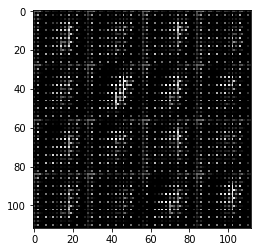

Epoch 1/2... Discriminator Loss: 0.2895... Generator Loss: 3.8333
Epoch 1/2... Discriminator Loss: 0.3181... Generator Loss: 1.7566
Epoch 1/2... Discriminator Loss: 0.0120... Generator Loss: 5.2037
Epoch 1/2... Discriminator Loss: 0.2631... Generator Loss: 1.6615
Epoch 1/2... Discriminator Loss: 0.0080... Generator Loss: 19.2602


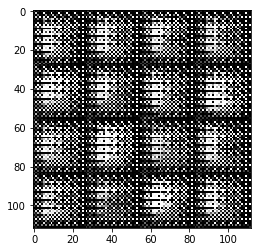

Epoch 1/2... Discriminator Loss: 0.0141... Generator Loss: 4.5528
Epoch 1/2... Discriminator Loss: 0.0008... Generator Loss: 12.7130
Epoch 1/2... Discriminator Loss: 0.0162... Generator Loss: 4.3301
Epoch 1/2... Discriminator Loss: 0.0024... Generator Loss: 12.9396
Epoch 1/2... Discriminator Loss: 1.5899... Generator Loss: 0.6920


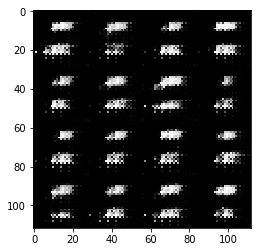

Epoch 1/2... Discriminator Loss: 0.4424... Generator Loss: 4.1815
Epoch 1/2... Discriminator Loss: 0.1101... Generator Loss: 4.7502
Epoch 1/2... Discriminator Loss: 2.4682... Generator Loss: 8.6917
Epoch 1/2... Discriminator Loss: 0.9815... Generator Loss: 0.9157
Epoch 1/2... Discriminator Loss: 1.9244... Generator Loss: 8.6599


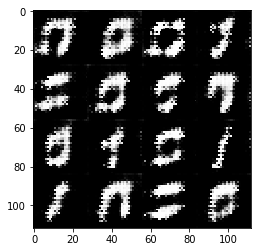

Epoch 1/2... Discriminator Loss: 3.0362... Generator Loss: 0.1854
Epoch 1/2... Discriminator Loss: 1.0605... Generator Loss: 2.9018
Epoch 1/2... Discriminator Loss: 0.5719... Generator Loss: 3.3713
Epoch 1/2... Discriminator Loss: 1.2365... Generator Loss: 3.6245
Epoch 1/2... Discriminator Loss: 0.9802... Generator Loss: 2.3242


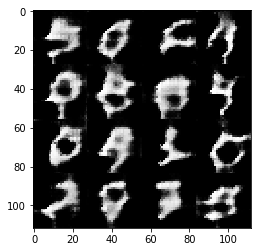

Epoch 1/2... Discriminator Loss: 0.7863... Generator Loss: 1.2147
Epoch 1/2... Discriminator Loss: 0.8902... Generator Loss: 1.8371
Epoch 1/2... Discriminator Loss: 2.1809... Generator Loss: 4.2394
Epoch 1/2... Discriminator Loss: 1.2336... Generator Loss: 0.6535
Epoch 1/2... Discriminator Loss: 0.7412... Generator Loss: 1.5847


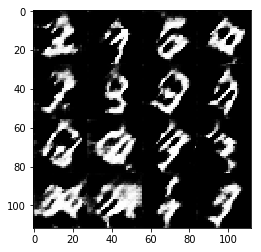

Epoch 1/2... Discriminator Loss: 0.7988... Generator Loss: 1.7358
Epoch 1/2... Discriminator Loss: 0.9554... Generator Loss: 1.0898
Epoch 1/2... Discriminator Loss: 1.0532... Generator Loss: 1.3002
Epoch 1/2... Discriminator Loss: 1.2741... Generator Loss: 0.6049
Epoch 1/2... Discriminator Loss: 0.8683... Generator Loss: 1.1366


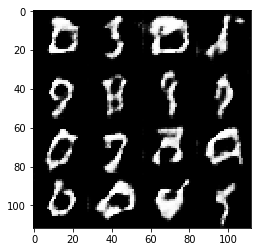

Epoch 1/2... Discriminator Loss: 1.0057... Generator Loss: 0.9365
Epoch 1/2... Discriminator Loss: 0.8869... Generator Loss: 2.1665
Epoch 1/2... Discriminator Loss: 1.0562... Generator Loss: 1.4140
Epoch 1/2... Discriminator Loss: 0.8810... Generator Loss: 1.1806
Epoch 1/2... Discriminator Loss: 1.0219... Generator Loss: 0.8858


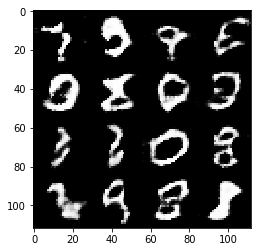

Epoch 1/2... Discriminator Loss: 0.9143... Generator Loss: 0.8907
Epoch 1/2... Discriminator Loss: 1.0396... Generator Loss: 0.9021
Epoch 1/2... Discriminator Loss: 0.9059... Generator Loss: 1.2896
Epoch 1/2... Discriminator Loss: 1.2447... Generator Loss: 0.6117
Epoch 1/2... Discriminator Loss: 0.9412... Generator Loss: 1.8591


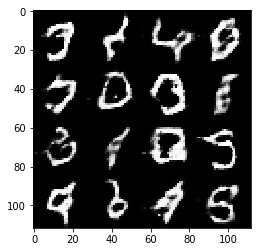

Epoch 1/2... Discriminator Loss: 0.9749... Generator Loss: 0.8864
Epoch 2/2... Discriminator Loss: 0.9305... Generator Loss: 1.2071
Epoch 2/2... Discriminator Loss: 0.9441... Generator Loss: 0.9690
Epoch 2/2... Discriminator Loss: 1.0405... Generator Loss: 1.7967
Epoch 2/2... Discriminator Loss: 1.0364... Generator Loss: 0.9235


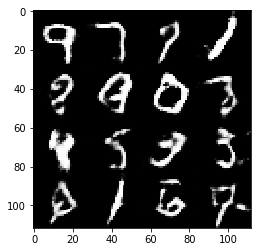

Epoch 2/2... Discriminator Loss: 1.0353... Generator Loss: 1.1878
Epoch 2/2... Discriminator Loss: 0.8926... Generator Loss: 0.9908
Epoch 2/2... Discriminator Loss: 0.8556... Generator Loss: 1.7229
Epoch 2/2... Discriminator Loss: 1.6167... Generator Loss: 0.4129
Epoch 2/2... Discriminator Loss: 0.9135... Generator Loss: 1.6329


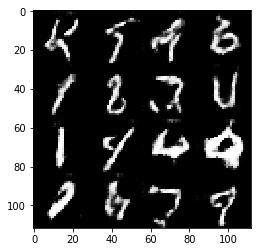

Epoch 2/2... Discriminator Loss: 1.4936... Generator Loss: 0.4133
Epoch 2/2... Discriminator Loss: 0.7792... Generator Loss: 1.6219
Epoch 2/2... Discriminator Loss: 1.7335... Generator Loss: 0.3369
Epoch 2/2... Discriminator Loss: 0.9089... Generator Loss: 1.1128
Epoch 2/2... Discriminator Loss: 1.4851... Generator Loss: 1.5835


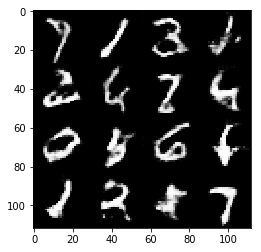

Epoch 2/2... Discriminator Loss: 1.1707... Generator Loss: 0.7808
Epoch 2/2... Discriminator Loss: 1.0880... Generator Loss: 0.8002
Epoch 2/2... Discriminator Loss: 1.0952... Generator Loss: 0.8401
Epoch 2/2... Discriminator Loss: 1.0917... Generator Loss: 0.7220
Epoch 2/2... Discriminator Loss: 1.1539... Generator Loss: 2.0158


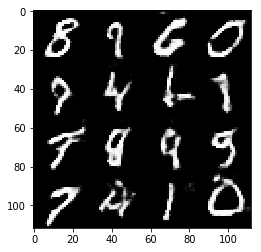

Epoch 2/2... Discriminator Loss: 0.9512... Generator Loss: 1.3688
Epoch 2/2... Discriminator Loss: 1.0297... Generator Loss: 2.0640
Epoch 2/2... Discriminator Loss: 1.3288... Generator Loss: 0.4894
Epoch 2/2... Discriminator Loss: 1.0185... Generator Loss: 0.8792
Epoch 2/2... Discriminator Loss: 1.0415... Generator Loss: 1.1188


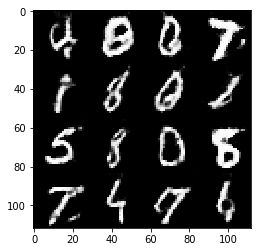

Epoch 2/2... Discriminator Loss: 0.9646... Generator Loss: 1.2720
Epoch 2/2... Discriminator Loss: 1.0633... Generator Loss: 1.6340
Epoch 2/2... Discriminator Loss: 1.4440... Generator Loss: 0.4895
Epoch 2/2... Discriminator Loss: 2.1360... Generator Loss: 0.1898
Epoch 2/2... Discriminator Loss: 1.3121... Generator Loss: 0.5483


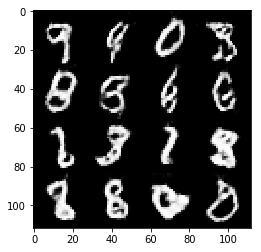

Epoch 2/2... Discriminator Loss: 1.1254... Generator Loss: 0.9585
Epoch 2/2... Discriminator Loss: 0.8576... Generator Loss: 1.2411
Epoch 2/2... Discriminator Loss: 2.5829... Generator Loss: 0.1441
Epoch 2/2... Discriminator Loss: 1.1561... Generator Loss: 1.3230
Epoch 2/2... Discriminator Loss: 1.2424... Generator Loss: 0.6260


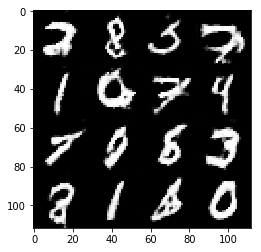

Epoch 2/2... Discriminator Loss: 0.8944... Generator Loss: 1.1060
Epoch 2/2... Discriminator Loss: 1.5421... Generator Loss: 1.9426
Epoch 2/2... Discriminator Loss: 1.0951... Generator Loss: 1.0841
Epoch 2/2... Discriminator Loss: 1.2832... Generator Loss: 1.7722
Epoch 2/2... Discriminator Loss: 0.9557... Generator Loss: 1.0439


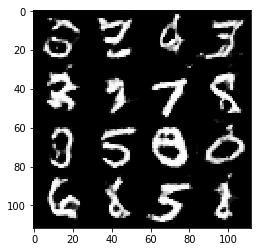

Epoch 2/2... Discriminator Loss: 2.2060... Generator Loss: 0.1781
Epoch 2/2... Discriminator Loss: 1.2782... Generator Loss: 0.5427
Epoch 2/2... Discriminator Loss: 1.2718... Generator Loss: 0.5808
Epoch 2/2... Discriminator Loss: 1.3352... Generator Loss: 0.5558
Epoch 2/2... Discriminator Loss: 1.2134... Generator Loss: 0.5882


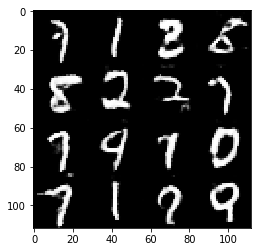

Epoch 2/2... Discriminator Loss: 1.1911... Generator Loss: 0.6710
Epoch 2/2... Discriminator Loss: 1.0879... Generator Loss: 1.5327
Epoch 2/2... Discriminator Loss: 1.0520... Generator Loss: 1.7956


In [34]:
batch_size = 128
z_dim = 128
learning_rate = 0.005
beta1 = 0.6


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.5034... Generator Loss: 11.5038
Epoch 1/1... Discriminator Loss: 2.0864... Generator Loss: 0.2531
Epoch 1/1... Discriminator Loss: 1.8444... Generator Loss: 9.7930
Epoch 1/1... Discriminator Loss: 2.0376... Generator Loss: 0.3339
Epoch 1/1... Discriminator Loss: 1.6669... Generator Loss: 0.5543


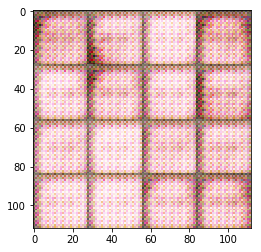

Epoch 1/1... Discriminator Loss: 1.3718... Generator Loss: 0.5562
Epoch 1/1... Discriminator Loss: 0.8665... Generator Loss: 1.0494
Epoch 1/1... Discriminator Loss: 0.6727... Generator Loss: 1.2286
Epoch 1/1... Discriminator Loss: 0.7575... Generator Loss: 0.9578
Epoch 1/1... Discriminator Loss: 0.5106... Generator Loss: 2.8484


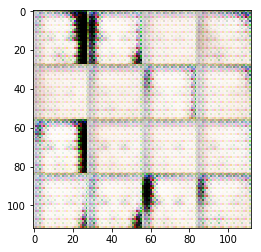

Epoch 1/1... Discriminator Loss: 0.6431... Generator Loss: 1.3186
Epoch 1/1... Discriminator Loss: 0.3586... Generator Loss: 1.8343
Epoch 1/1... Discriminator Loss: 1.3627... Generator Loss: 1.4538
Epoch 1/1... Discriminator Loss: 1.2888... Generator Loss: 5.7632
Epoch 1/1... Discriminator Loss: 0.4211... Generator Loss: 1.5821


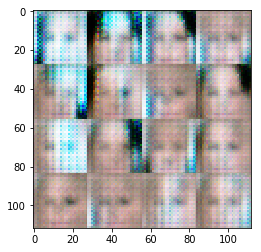

Epoch 1/1... Discriminator Loss: 1.7443... Generator Loss: 0.2554
Epoch 1/1... Discriminator Loss: 1.4792... Generator Loss: 0.6019
Epoch 1/1... Discriminator Loss: 0.6194... Generator Loss: 1.5697
Epoch 1/1... Discriminator Loss: 1.1150... Generator Loss: 0.8320
Epoch 1/1... Discriminator Loss: 2.7815... Generator Loss: 4.6667


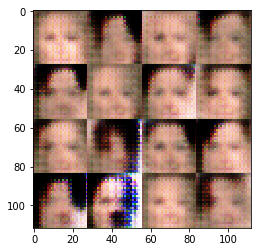

Epoch 1/1... Discriminator Loss: 1.3685... Generator Loss: 0.4389
Epoch 1/1... Discriminator Loss: 0.7794... Generator Loss: 0.9611
Epoch 1/1... Discriminator Loss: 0.7913... Generator Loss: 1.1258
Epoch 1/1... Discriminator Loss: 0.8465... Generator Loss: 1.0346
Epoch 1/1... Discriminator Loss: 0.7440... Generator Loss: 1.9264


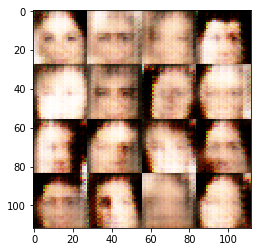

Epoch 1/1... Discriminator Loss: 0.9422... Generator Loss: 0.8598
Epoch 1/1... Discriminator Loss: 1.3719... Generator Loss: 2.5220
Epoch 1/1... Discriminator Loss: 0.8204... Generator Loss: 1.0324
Epoch 1/1... Discriminator Loss: 0.9273... Generator Loss: 0.8355
Epoch 1/1... Discriminator Loss: 1.5416... Generator Loss: 2.9999


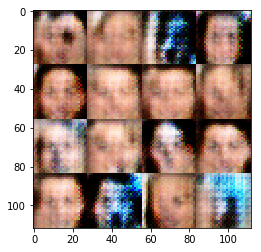

Epoch 1/1... Discriminator Loss: 0.9708... Generator Loss: 1.8612
Epoch 1/1... Discriminator Loss: 1.1252... Generator Loss: 2.0497
Epoch 1/1... Discriminator Loss: 1.9932... Generator Loss: 0.2506
Epoch 1/1... Discriminator Loss: 0.9789... Generator Loss: 0.9729
Epoch 1/1... Discriminator Loss: 0.6873... Generator Loss: 2.3255


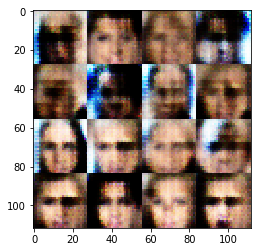

Epoch 1/1... Discriminator Loss: 0.9419... Generator Loss: 1.4706
Epoch 1/1... Discriminator Loss: 0.9152... Generator Loss: 1.9695
Epoch 1/1... Discriminator Loss: 1.9488... Generator Loss: 0.2418
Epoch 1/1... Discriminator Loss: 0.9252... Generator Loss: 0.6796
Epoch 1/1... Discriminator Loss: 1.0817... Generator Loss: 0.7200


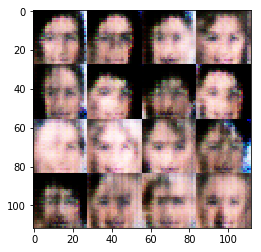

Epoch 1/1... Discriminator Loss: 0.5802... Generator Loss: 1.9344
Epoch 1/1... Discriminator Loss: 1.3406... Generator Loss: 0.4174
Epoch 1/1... Discriminator Loss: 0.9769... Generator Loss: 0.6847
Epoch 1/1... Discriminator Loss: 1.0442... Generator Loss: 1.3960
Epoch 1/1... Discriminator Loss: 1.2349... Generator Loss: 1.9768


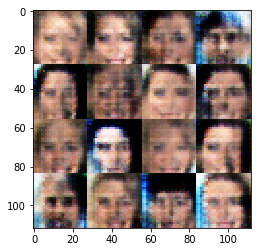

Epoch 1/1... Discriminator Loss: 0.6305... Generator Loss: 2.5466
Epoch 1/1... Discriminator Loss: 1.0778... Generator Loss: 0.7769
Epoch 1/1... Discriminator Loss: 1.0686... Generator Loss: 1.2371
Epoch 1/1... Discriminator Loss: 0.6094... Generator Loss: 1.2157
Epoch 1/1... Discriminator Loss: 1.0636... Generator Loss: 0.8326


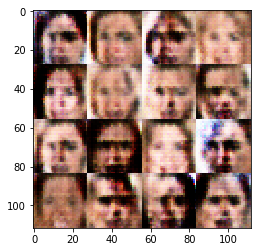

Epoch 1/1... Discriminator Loss: 1.2356... Generator Loss: 0.5205
Epoch 1/1... Discriminator Loss: 1.1357... Generator Loss: 0.6614
Epoch 1/1... Discriminator Loss: 1.0536... Generator Loss: 0.7730
Epoch 1/1... Discriminator Loss: 0.8943... Generator Loss: 1.1311
Epoch 1/1... Discriminator Loss: 0.8596... Generator Loss: 1.6992


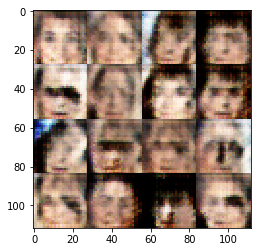

Epoch 1/1... Discriminator Loss: 0.7658... Generator Loss: 1.2734
Epoch 1/1... Discriminator Loss: 0.7740... Generator Loss: 1.0425
Epoch 1/1... Discriminator Loss: 0.9772... Generator Loss: 0.8046
Epoch 1/1... Discriminator Loss: 0.6739... Generator Loss: 1.1850
Epoch 1/1... Discriminator Loss: 0.6941... Generator Loss: 2.2104


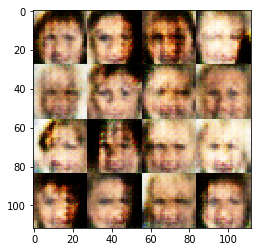

Epoch 1/1... Discriminator Loss: 1.4166... Generator Loss: 0.5636
Epoch 1/1... Discriminator Loss: 0.6857... Generator Loss: 1.5506
Epoch 1/1... Discriminator Loss: 1.0499... Generator Loss: 2.4730
Epoch 1/1... Discriminator Loss: 0.6402... Generator Loss: 1.2503
Epoch 1/1... Discriminator Loss: 0.7083... Generator Loss: 1.7158


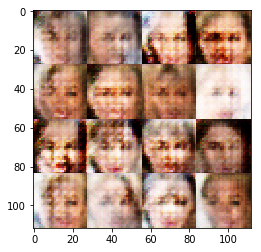

Epoch 1/1... Discriminator Loss: 0.6177... Generator Loss: 1.3333
Epoch 1/1... Discriminator Loss: 0.8961... Generator Loss: 1.6344
Epoch 1/1... Discriminator Loss: 0.9386... Generator Loss: 0.8219
Epoch 1/1... Discriminator Loss: 0.5722... Generator Loss: 1.4240
Epoch 1/1... Discriminator Loss: 1.2874... Generator Loss: 0.5424


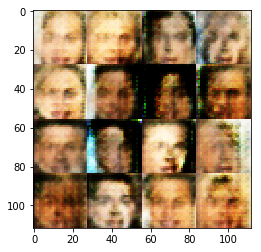

Epoch 1/1... Discriminator Loss: 0.6829... Generator Loss: 1.4539
Epoch 1/1... Discriminator Loss: 0.9589... Generator Loss: 1.2349
Epoch 1/1... Discriminator Loss: 0.9590... Generator Loss: 1.4161
Epoch 1/1... Discriminator Loss: 0.8740... Generator Loss: 1.3164
Epoch 1/1... Discriminator Loss: 1.3221... Generator Loss: 0.6239


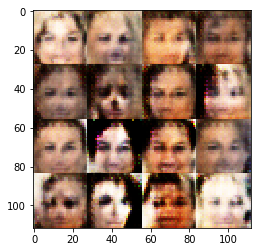

Epoch 1/1... Discriminator Loss: 0.9283... Generator Loss: 1.5498
Epoch 1/1... Discriminator Loss: 0.7243... Generator Loss: 1.4598
Epoch 1/1... Discriminator Loss: 0.9628... Generator Loss: 1.1390
Epoch 1/1... Discriminator Loss: 0.7131... Generator Loss: 1.1270
Epoch 1/1... Discriminator Loss: 0.8541... Generator Loss: 1.3934


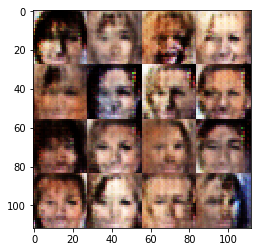

Epoch 1/1... Discriminator Loss: 1.3575... Generator Loss: 0.5177
Epoch 1/1... Discriminator Loss: 0.9571... Generator Loss: 2.2047
Epoch 1/1... Discriminator Loss: 1.5272... Generator Loss: 0.4359
Epoch 1/1... Discriminator Loss: 1.0981... Generator Loss: 0.7867
Epoch 1/1... Discriminator Loss: 0.9060... Generator Loss: 0.8602


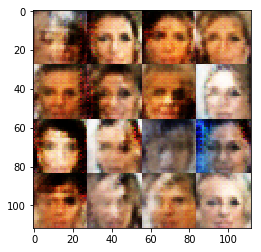

Epoch 1/1... Discriminator Loss: 0.9543... Generator Loss: 1.5690
Epoch 1/1... Discriminator Loss: 1.0019... Generator Loss: 1.0994
Epoch 1/1... Discriminator Loss: 0.8271... Generator Loss: 0.9081
Epoch 1/1... Discriminator Loss: 0.6952... Generator Loss: 1.1434
Epoch 1/1... Discriminator Loss: 1.1605... Generator Loss: 0.5899


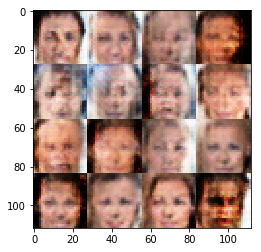

Epoch 1/1... Discriminator Loss: 0.9613... Generator Loss: 0.7554
Epoch 1/1... Discriminator Loss: 0.8749... Generator Loss: 1.3393
Epoch 1/1... Discriminator Loss: 0.8958... Generator Loss: 0.8033
Epoch 1/1... Discriminator Loss: 0.7747... Generator Loss: 1.0218
Epoch 1/1... Discriminator Loss: 0.7139... Generator Loss: 1.4890


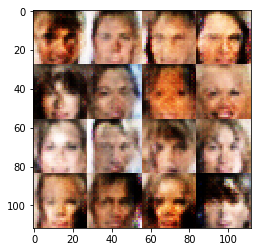

Epoch 1/1... Discriminator Loss: 1.0143... Generator Loss: 2.6540
Epoch 1/1... Discriminator Loss: 1.1363... Generator Loss: 2.0332
Epoch 1/1... Discriminator Loss: 0.9445... Generator Loss: 0.9473
Epoch 1/1... Discriminator Loss: 0.8485... Generator Loss: 1.0358
Epoch 1/1... Discriminator Loss: 0.8065... Generator Loss: 1.2750


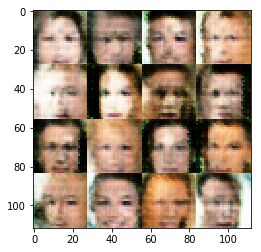

Epoch 1/1... Discriminator Loss: 0.6970... Generator Loss: 1.0682
Epoch 1/1... Discriminator Loss: 0.8638... Generator Loss: 1.3900
Epoch 1/1... Discriminator Loss: 0.8642... Generator Loss: 1.2917
Epoch 1/1... Discriminator Loss: 0.9199... Generator Loss: 0.8613
Epoch 1/1... Discriminator Loss: 1.0437... Generator Loss: 1.2041


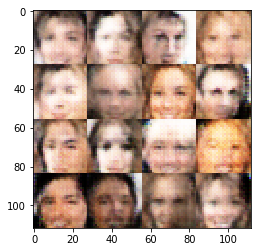

Epoch 1/1... Discriminator Loss: 0.9074... Generator Loss: 0.9543
Epoch 1/1... Discriminator Loss: 1.1417... Generator Loss: 1.6347
Epoch 1/1... Discriminator Loss: 0.7174... Generator Loss: 1.3945
Epoch 1/1... Discriminator Loss: 0.7526... Generator Loss: 1.4135
Epoch 1/1... Discriminator Loss: 0.9429... Generator Loss: 1.0902


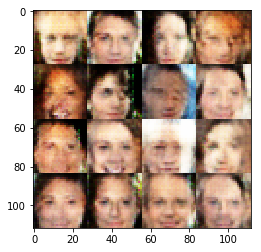

Epoch 1/1... Discriminator Loss: 1.0095... Generator Loss: 1.3834
Epoch 1/1... Discriminator Loss: 0.9210... Generator Loss: 1.1080
Epoch 1/1... Discriminator Loss: 1.0610... Generator Loss: 0.9458
Epoch 1/1... Discriminator Loss: 0.7584... Generator Loss: 1.4307
Epoch 1/1... Discriminator Loss: 1.0149... Generator Loss: 1.1001


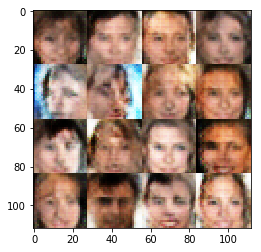

Epoch 1/1... Discriminator Loss: 0.9014... Generator Loss: 1.6638
Epoch 1/1... Discriminator Loss: 0.9061... Generator Loss: 1.2757
Epoch 1/1... Discriminator Loss: 0.8394... Generator Loss: 1.9947
Epoch 1/1... Discriminator Loss: 1.1771... Generator Loss: 0.7977
Epoch 1/1... Discriminator Loss: 0.9274... Generator Loss: 0.7928


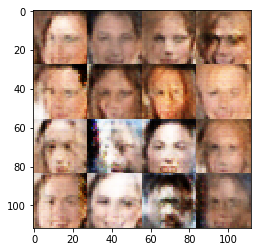

Epoch 1/1... Discriminator Loss: 1.7010... Generator Loss: 0.2995
Epoch 1/1... Discriminator Loss: 0.9472... Generator Loss: 0.9042
Epoch 1/1... Discriminator Loss: 1.0907... Generator Loss: 0.6884
Epoch 1/1... Discriminator Loss: 0.8789... Generator Loss: 1.0112
Epoch 1/1... Discriminator Loss: 0.7519... Generator Loss: 1.4907


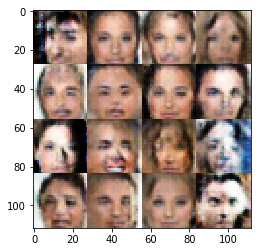

Epoch 1/1... Discriminator Loss: 1.0091... Generator Loss: 0.8694
Epoch 1/1... Discriminator Loss: 0.9456... Generator Loss: 1.2736
Epoch 1/1... Discriminator Loss: 0.6938... Generator Loss: 2.0890
Epoch 1/1... Discriminator Loss: 0.8985... Generator Loss: 1.3997
Epoch 1/1... Discriminator Loss: 0.9134... Generator Loss: 1.3534


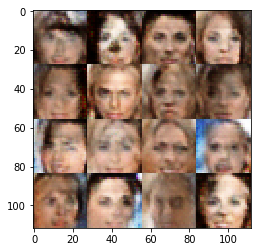

Epoch 1/1... Discriminator Loss: 1.2500... Generator Loss: 0.5700
Epoch 1/1... Discriminator Loss: 0.8391... Generator Loss: 1.2544
Epoch 1/1... Discriminator Loss: 0.7258... Generator Loss: 1.6062
Epoch 1/1... Discriminator Loss: 0.9269... Generator Loss: 0.8829
Epoch 1/1... Discriminator Loss: 0.8502... Generator Loss: 1.2046


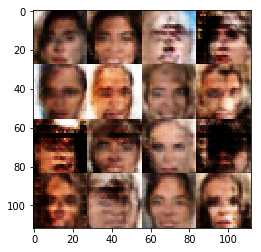

Epoch 1/1... Discriminator Loss: 0.8637... Generator Loss: 1.2488
Epoch 1/1... Discriminator Loss: 0.8759... Generator Loss: 0.9660
Epoch 1/1... Discriminator Loss: 1.3063... Generator Loss: 1.6982
Epoch 1/1... Discriminator Loss: 0.8438... Generator Loss: 1.1795
Epoch 1/1... Discriminator Loss: 0.9372... Generator Loss: 1.2249


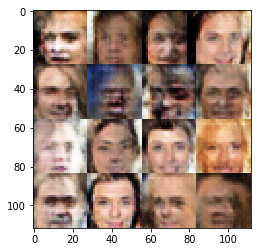

Epoch 1/1... Discriminator Loss: 1.0612... Generator Loss: 0.7303
Epoch 1/1... Discriminator Loss: 1.2538... Generator Loss: 0.5682
Epoch 1/1... Discriminator Loss: 0.9721... Generator Loss: 1.0465
Epoch 1/1... Discriminator Loss: 1.0601... Generator Loss: 1.1455
Epoch 1/1... Discriminator Loss: 0.8947... Generator Loss: 1.3387


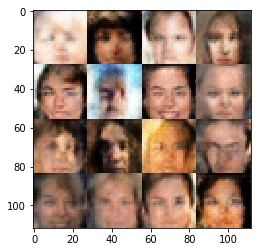

Epoch 1/1... Discriminator Loss: 1.2847... Generator Loss: 0.6262
Epoch 1/1... Discriminator Loss: 0.8410... Generator Loss: 1.2596
Epoch 1/1... Discriminator Loss: 1.0213... Generator Loss: 1.6711
Epoch 1/1... Discriminator Loss: 1.1986... Generator Loss: 0.5978
Epoch 1/1... Discriminator Loss: 1.1731... Generator Loss: 2.2944


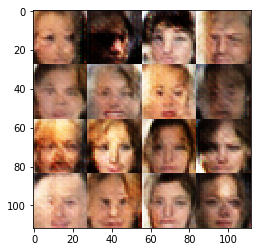

Epoch 1/1... Discriminator Loss: 1.0201... Generator Loss: 0.7673
Epoch 1/1... Discriminator Loss: 1.0419... Generator Loss: 0.7021
Epoch 1/1... Discriminator Loss: 0.9743... Generator Loss: 1.8571
Epoch 1/1... Discriminator Loss: 0.8550... Generator Loss: 1.1815
Epoch 1/1... Discriminator Loss: 0.9229... Generator Loss: 1.5434


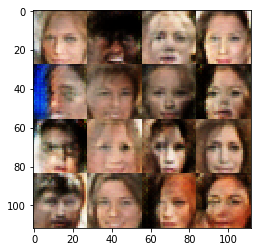

Epoch 1/1... Discriminator Loss: 1.0356... Generator Loss: 0.7212
Epoch 1/1... Discriminator Loss: 1.0259... Generator Loss: 1.4741
Epoch 1/1... Discriminator Loss: 0.9653... Generator Loss: 0.7559


In [37]:
batch_size = 128
z_dim = 128
learning_rate = 0.001
beta1 = 0.6


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.